In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1
import warnings
warnings.filterwarnings('ignore')

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import os
import pathlib
import pandas as pd
from PIL import Image
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

In [0]:
IMAGE_WIDTH = 160
IMAGE_HEIGHT = 160
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32

In [4]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [5]:
# path to the data folder
data_root = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/')

# path to the raw data source folder
data_source = pathlib.Path('/content/gdrive/My Drive/Team2data/')

# path to the preprocessed data folder
data_cleaned_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/cleaned_source/')

# path to where we save the trained model
export_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models/')

print(data_root)
print(data_source)
print(data_cleaned_source)
print(export_path)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data
/content/gdrive/My Drive/Team2data
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/cleaned_source
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models


In [6]:
from collections import Counter

# Find all labels
labels = [x.name for x in data_source.glob('*') if x.is_dir()]
label_names = sorted(item.name for item in data_source.glob('*/') if item.is_dir())
print('all labels:', label_names)

# Find all image's path
all_image_paths = list(data_source.glob("*/*"))
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]

# Find all image's labels
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

# Count #image each class
count = Counter()

for label in all_image_labels:
  count[label_names[label]] += 1
  
count


###########################################

from sklearn.model_selection import train_test_split
from collections import Counter

# set the path to the data source folder
final_data_source = data_cleaned_source

# Find all labels
labels = [x.name for x in final_data_source.glob('*') if x.is_dir()]
label_names = sorted(item.name for item in final_data_source.glob('*/') if item.is_dir())
label_names = np.array(label_names)
print('all labels:', label_names)

# Find all image's path
all_image_paths = list(final_data_source.glob("*/*"))
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]

# Find all image's labels
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

# Count #image each class
count = Counter()

for label in all_image_labels:
  count[label_names[label]] += 1
  
print(count)

train_image_paths, val_image_paths, train_image_labels, val_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.1, random_state=101)

total_train_images = len(train_image_paths)
total_val_images = len(val_image_paths)

print('total train images:', total_train_images)
print('total validation images:', total_val_images)

# Find all train & validation image's labels
train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in train_image_paths]

val_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in val_image_paths]

# Count # of train image each class
train_count = Counter()
val_count = Counter()

for label in train_image_labels:
  train_count[label_names[label]] += 1
  
for label in val_image_labels:
  val_count[label_names[label]] += 1
  
print("total train images by each label:\n", train_count)
print("total validation images by each label:\n", val_count)


all labels: ['paper', 'rock', 'scissors']
all labels: ['paper' 'rock' 'scissors']
Counter({'paper': 3029, 'rock': 2954, 'scissors': 2860})
total train images: 7958
total validation images: 885
total train images by each label:
 Counter({'paper': 2728, 'rock': 2645, 'scissors': 2585})
total validation images by each label:
 Counter({'rock': 309, 'paper': 301, 'scissors': 275})


In [7]:
df_train = pd.DataFrame({'paths':train_image_paths, 'labels':label_names[train_image_labels]})
df_val = pd.DataFrame({'paths':val_image_paths, 'labels':label_names[val_image_labels]})

# Preprocess Train dataset
train_img_datagen = ImageDataGenerator(
                                        rescale=1./255,
                                        rotation_range=40,
#                                         zoom_range=0.15,
#                                         width_shift_range=0.2,
#                                         height_shift_range=0.2,
#                                         shear_range=0.15,
                                        brightness_range = (1, 1.5),
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode="nearest"
                                      )

train_generator = train_img_datagen.flow_from_dataframe(df_train,
                                                 x_col='paths',
                                                 y_col='labels',
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 class_mode='sparse',
                                                 target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))

# Preprocess Validation dataset
validation_img_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_img_datagen.flow_from_dataframe(df_val,
                                                 x_col='paths',
                                                 y_col='labels',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))





Found 7958 validated image filenames belonging to 3 classes.
Found 885 validated image filenames belonging to 3 classes.


In [8]:
# create a model with transfer learning from MobileNet model
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False)
mobile_net.trainable=False
base_learning_rate = 0.0001

def create_model_tl():
  model = tf.keras.Sequential([
      mobile_net,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(len(label_names), activation = 'softmax')])
  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#   model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model

model_tl = create_model_tl()
model_tl.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D

# def create_model():
  
#   model = tf.keras.Sequential()
  
#   model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))
  
#   model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Flatten())
#   model.add(Dense(1024, activation='relu'))
#   model.add(BatchNormalization())
#   model.add(Dropout(0.2))
# #   model.add(GlobalAveragePooling2D()),
#   model.add(Dense(len(label_names), activation='softmax')) 
#   model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# #   model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

#   return model

# model = create_model()
# model.summary()

## TRAIN MODEL

In [0]:
CHECKPOINT_MODEL_NAME = 'checkpoint-model_tl_ep60_160x160.h5'
EXPORT_MODEL_NAME = 'my_model_tl_ep60_160x160.h5'
initial_epochs = 30
fine_tune_epochs = 30

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
#         self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
#         self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()
callbacks = [
#     EarlyStopping(patience=10, verbose=1),
    batch_stats_callback,
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1), # learning rate decay
    ModelCheckpoint(os.path.join(export_path, CHECKPOINT_MODEL_NAME), verbose=1, save_best_only=True)
]

In [12]:
history_tl = model_tl.fit_generator(
    train_generator,
    steps_per_epoch=total_train_images // BATCH_SIZE,
    epochs=initial_epochs,
    validation_data=validation_generator,
    validation_steps=total_val_images // BATCH_SIZE,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
247/248 [============================>.] - ETA: 1s - loss: 1.0832 - accuracy: 0.4529
Epoch 00001: val_loss improved from inf to 0.92413, saving model to /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models/checkpoint-model_tl_ep60_160x160.h5
248/248 [==============================] - 551s 2s/step - loss: 1.0818 - accuracy: 0.4537 - val_loss: 0.9241 - val_accuracy: 0.5521
Epoch 2/30
247/248 [============================>.] - ETA: 0s - loss: 0.8269 - accuracy: 0.6217
Epoch 00002: val_loss improved from 0.92413 to 0.76068, saving model to /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models/checkpoint-model_tl_ep60_160x160.h5
248/248 [==============================] - 136s 547ms/step - loss: 0.8263 - accuracy: 0.6223 - val_loss: 0.7607 - val_accuracy: 0.6528
Epoch 3/30
247/248 [===

<Figure size 432x288 with 0 Axes>

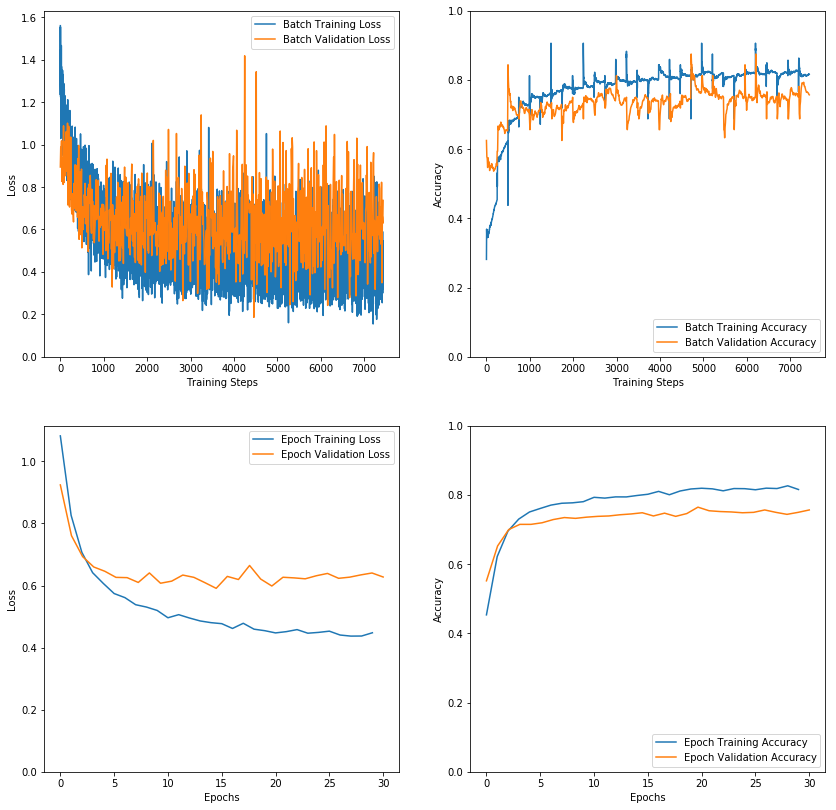

In [13]:
def plot_training_results(training_acc, training_losses, val_acc, val_losses, epoch_acc, epoch_val_acc, epoch_loss, epoch_val_loss):
  plt.figure()
  fig, ax = plt.subplots(2, 2, figsize=[14, 14])
  
  # Plot batch's training & validation losses
  ax[0, 0].set_ylabel("Loss")
  ax[0, 0].set_xlabel("Training Steps")

  training_steps = len(training_losses)
  test_steps = len(val_losses)
  ax[0, 0].plot(training_losses, label='Batch Training Loss')
  ax[0, 0].plot(np.linspace(0, training_steps, test_steps), val_losses, label='Batch Validation Loss')
  ax[0, 0].set_ylim([0,max(ax[0, 0].set_ylim())])
  ax[0, 0].legend(loc='upper right')

  # Plot batchs training & validation accuracy
  ax[0, 1].set_ylabel("Accuracy")
  ax[0, 1].set_xlabel("Training Steps")

  training_steps = len(training_acc)
  test_steps = len(val_acc)
  ax[0, 1].plot(training_acc, label='Batch Training Accuracy')
  ax[0, 1].plot(np.linspace(0, training_steps, test_steps), val_acc, label='Batch Validation Accuracy')
  ax[0, 1].set_ylim([0,1])
  ax[0, 1].legend(loc='lower right')

  # Plot epochs training & validation losses
  ax[1, 0].set_ylabel("Loss")
  ax[1, 0].set_xlabel("Epochs")

  train_epochs = len(epoch_loss)
  val_epochs = len(epoch_val_loss)
  ax[1, 0].plot(epoch_loss, label='Epoch Training Loss')
  ax[1, 0].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_loss, label='Epoch Validation Loss')
  ax[1, 0].set_ylim([0,max(ax[1, 0].set_ylim())])
  ax[1, 0].legend(loc='upper right')
  
  # Plot epochs training & validation accuracy
  ax[1, 1].set_ylabel("Accuracy")
  ax[1, 1].set_xlabel("Epochs")

  train_epochs = len(epoch_acc)
  val_epochs = len(epoch_val_acc)
  ax[1, 1].plot(epoch_acc, label='Epoch Training Accuracy')
  ax[1, 1].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_acc, label='Epoch Validation Accuracy')
  ax[1, 1].set_ylim([0,1])
  ax[1, 1].legend(loc='lower right')
    
  plt.show()

plot_training_results(batch_stats_callback.batch_acc,
                      batch_stats_callback.batch_losses, 
                      batch_stats_callback.batch_val_acc, 
                      batch_stats_callback.batch_val_losses,
                      history_tl.history['accuracy'],
                      history_tl.history['val_accuracy'],
                      history_tl.history['loss'],
                      history_tl.history['val_loss']
                     )

Image batch shape:  (32, 160, 160, 3)
Label batch shape:  (32,)


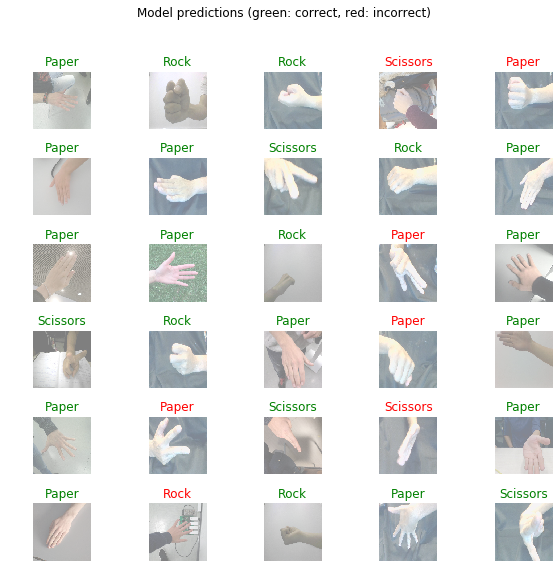

In [14]:
for image_batch, label_batch in validation_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break
  
  
# Predict
label_names = np.array(label_names)
predicted_batch = model_tl.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]


# Plot the result
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow((image_batch[n]+1)/2)
  color = "green" if predicted_id[n] == label_batch[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [15]:
mobile_net.trainable=True


print("Number of layers in the base model:", len(mobile_net.layers))

fine_tune_at = 140

for layer in mobile_net.layers[:fine_tune_at]:
    layer.trainable = False
    
    
    
model_tl.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
# model_tl.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

model_tl.summary()


#########################

total_epochs = initial_epochs + fine_tune_epochs

history_tl = model_tl.fit_generator(
    train_generator,
    steps_per_epoch=total_train_images // BATCH_SIZE,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=total_val_images // BATCH_SIZE,
    initial_epoch=initial_epochs,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

Number of layers in the base model: 155
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,043,843
Non-trainable params: 1,217,984
_________________________________________________________________
Epoch 31/60
247/248 [============================>.] - ETA: 0s - loss: 0.4248 - accuracy: 0.8280
Epoch 00031: val_loss improved from 0.59098 to 0.55126, saving model to /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models/checkpoint-model_tl_ep60_160x160.h5
248/248 [========

<Figure size 432x288 with 0 Axes>

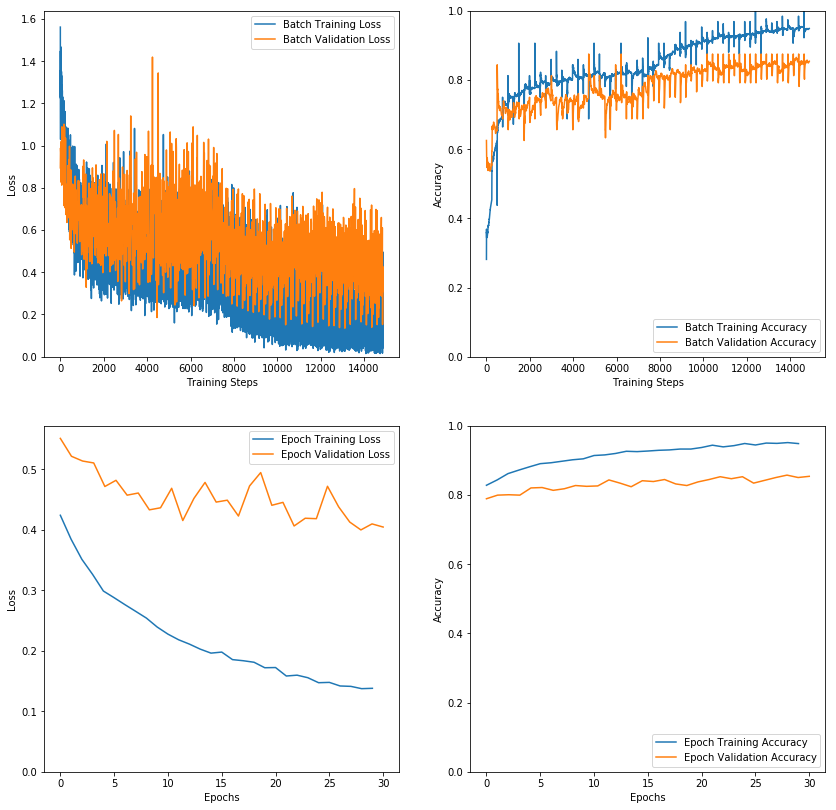

In [16]:
plot_training_results(batch_stats_callback.batch_acc,
                      batch_stats_callback.batch_losses, 
                      batch_stats_callback.batch_val_acc, 
                      batch_stats_callback.batch_val_losses,
                      history_tl.history['accuracy'],
                      history_tl.history['val_accuracy'],
                      history_tl.history['loss'],
                      history_tl.history['val_loss']
                     )

In [0]:
#Save the entire model to a HDF5 file
model_tl.save(os.path.join(export_path, EXPORT_MODEL_NAME))